In [ ]:
'''
This script decodes the generated latent embedding into the gene expression matrix and draw the UMAP for the generated cells and real cells
''' 

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

from pathlib import Path
# Detect project root when notebook runs from the notebooks/ directory
PROJECT_ROOT = Path.cwd()
if PROJECT_ROOT.name == 'notebooks':
    PROJECT_ROOT = PROJECT_ROOT.parent

# make repo root importable and consistent when loading files
import sys
sys.path.append(str(PROJECT_ROOT))
print(f"Project root: {PROJECT_ROOT}")
import anndata as ad
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from scipy import stats
import torch
from src.VAE.VAE_model import VAE
# NOTE: sys.path already extended above using PROJECT_ROOT

Project root: /Users/surprisedcat/DTU/DL


load AE. Change the path of autoencoder to your local path

In [2]:
# modify the num_genes if use your own dataset

def load_VAE():
    autoencoder = VAE(
        num_genes=adata_subset.shape[1],
        device='mps',
        seed=0,
        loss_ae='mse',
        hidden_dim=128,
        decoder_activation='ReLU',
    )
    autoencoder.load_state_dict(torch.load(str(PROJECT_ROOT / 'weights' / 'modelvae.pt'), map_location=torch.device('cpu')))
    return autoencoder



load real data for comparision

In [3]:
adata = sc.read_h5ad(str(PROJECT_ROOT / 'data' / 'bulk_processed_transcripts.h5ad'), backed='r')
adata_subset = adata[:5000].to_memory()
adata_subset.var_names_make_unique()
adata_subset = adata_subset.copy()
print("data loaded")

sc.pp.filter_cells(adata_subset, min_genes=10)

gene_names = adata.var_names

sc.pp.normalize_total(adata_subset, target_sum=1e4)
sc.pp.log1p(adata_subset)
print("Data normalized and log-transformed.")

cell_data = adata_subset.X
# Conversion sparse -> dense si nécessaire
if hasattr(cell_data, "toarray"):
    cell_data = cell_data.toarray()

celltype = adata_subset.obs['leiden']
print(f"Cell types: {celltype.unique()}")
print(f"Original data shape: {cell_data.shape}")


data loaded
Data normalized and log-transformed.
Cell types: ['0', '1', '3', '4', '2']
Categories (5, object): ['0', '1', '2', '3', '4']
Original data shape: (5000, 162009)


In [ ]:
# # Saving data normalized and log-transformed
# np.save(str(PROJECT_ROOT / 'data' / 'cell_gen_normalized.npy'), cell_data)
# print("Normalized data saved.")

load and decode unconditional generated data

In [4]:
npzfile=np.load(str(PROJECT_ROOT / 'data' / 'bulk_250000.npz')) # change this path to your local path
cell_gen_all = npzfile['cell_gen'][:5000]

autoencoder = load_VAE()
cell_gen = autoencoder(torch.tensor(cell_gen_all).to(device='mps'), return_decoded=True).cpu().detach().numpy()
cell_gen.shape

(5000, 162009)

load and decode conditional generated data

In [5]:
# if not generated all type of cells, use the real cell to balance the batchnorm in the scimilarity
adata_w = adata_subset.copy()
#adata_w.var_names = gene_names

autoencoder = load_VAE()
cell_w = autoencoder(torch.tensor(adata_w.X.toarray()).to(device='mps'), return_latent=True).detach().cpu().numpy()

# concat this cell_w with cell_gen and send them to the autoencoder
#cell_gen_all = autoencoder(torch.tensor(np.concatenate((cell_gen,cell_w),axis=0)).cuda(),return_decoded=True).cpu().detach().numpy()
cell_w.shape

(5000, 128)

In [ ]:
cell_w.std(),cell_w.mean()

In [ ]:
data = cell_w.reshape(-1)
num_bins = 150  # 设定区间数量
counts, bins, _ = plt.hist(data, bins=num_bins, edgecolor='black')


In [ ]:
data.min(),data.max(),abs(data).mean()

In [ ]:
plt.figure()
plt.ylim((-0.2,+0.2))
plt.xlim((-0.2,+0.2))
plt.ylabel('the gene expression of gen cells')
plt.xlabel('the gene expression of real cells')
plt.scatter(cell_w.mean(axis=0),cell_gen_all.mean(axis=0))
# plt.scatter(np.expm1(cell_data).mean(axis=0),np.expm1(cell_gen).mean(axis=0))
plt.plot([-0.4,+0.4],[-0.4,+0.4],color='orange')

In [ ]:
plt.figure()
# plt.ylim((-0.2,+0.2))
# plt.xlim((-0.2,+0.2))
plt.ylabel('the gene expression of gen cells')
plt.xlabel('the gene expression of real cells')
plt.scatter(cell_data.mean(axis=0),cell_gen.mean(axis=0))
# plt.scatter(np.expm1(cell_data).mean(axis=0),np.expm1(cell_gen).mean(axis=0))
# plt.plot([-0.4,+0.4],[-0.4,+0.4],color='orange')

In [ ]:
plt.figure()
plt.ylim((-0.2,+0.2))
plt.xlim((-0.2,+0.2))
plt.ylabel('the gene expression of gen cells')
plt.xlabel('the gene expression of real cells')
plt.scatter(cell_w.mean(axis=0),cell_gen_all.mean(axis=0))
# plt.scatter(np.expm1(cell_data).mean(axis=0),np.expm1(cell_gen).mean(axis=0))
plt.plot([-0.4,+0.4],[-0.4,+0.4],color='orange')

In [6]:
# 1. Définition automatique du device
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

print(f"Using device: {device}")

# 2. Chargement et préparation des données (identique à votre logique)
cell_gen_all = []
gen_class = []
# Assurez-vous que adata_subset est défini précédemment
if 'adata_subset' in locals():
    cato = list(adata_subset.obs['leiden'].cat.categories)
    index2 = range(len(cato))

    for i in index2:
        # Remplacez par votre chemin local si nécessaire
        npz_path = str(PROJECT_ROOT / 'data' / 'bulk_250000.npz') 
        npzfile = np.load(npz_path) 
        
        # Filtrage logique
        mask = adata_subset.obs['leiden'] == cato[i]
        length = min(adata_subset[mask].shape[0], 6000)
        
        # Récupération des données
        cell_gen_all.append(npzfile['cell_gen'][:int(length)])
        gen_class += ['gen ' + cato[i]] * int(length)

    cell_gen_all = np.concatenate(cell_gen_all, axis=0)
else:
    print("Warning: adata_subset is not defined. Skipping data loading loop.")
    # Pour le test si adata_subset n'est pas là, on crée un dummy array
    # cell_gen_all = np.random.randn(10, 128).astype(np.float32) 

# 3. Chargement du modèle et transfert sur le Device
autoencoder = load_VAE() # Charge le modèle (par défaut sur CPU ou CUDA selon la fonction)
autoencoder.to(device)   # IMPORTANT : Force le modèle sur le bon device (MPS/CUDA)
autoencoder.eval()       # Toujours passer en mode eval pour l'inférence

# 4. Inférence
# On convertit les données en tenseur float32 (format attendu par PyTorch)
tensor_input = torch.tensor(cell_gen_all, dtype=torch.float32).to(device)

with torch.no_grad(): # Désactive le calcul des gradients pour économiser la mémoire
    decoded_output = autoencoder(tensor_input, return_decoded=True)

# On ramène sur CPU pour numpy
cell_gen = decoded_output.cpu().detach().numpy()

print(f"Output shape: {cell_gen.shape}")


Using device: mps
Output shape: (5000, 162009)


plot UMAP

In [7]:
adata = np.concatenate((cell_data, cell_gen),axis=0)
adata = ad.AnnData(adata, dtype=np.float32)

# if conditional generate. other wise commented this.
# adata.obs['celltype'] = np.concatenate((celltype, gen_class))

adata.obs['cell_name'] = [f"true_Cell" for i in range(cell_data.shape[0])]+[f"gen_Cell" for i in range(cell_gen.shape[0])]

/Users/surprisedcat/DTU/DL/venv/lib/python3.13/site-packages/legacy_api_wrap/__init__.py:88: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  return fn(*args_all, **kw)


In [8]:
# the data is already log norm
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata.raw = adata
adata = adata[:, adata.var.highly_variable]

sc.pp.scale(adata)
sc.tl.pca(adata, svd_solver='arpack')

/Users/surprisedcat/DTU/DL/venv/lib/python3.13/site-packages/scanpy/preprocessing/_scale.py:309: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


draw plot of all cells if unconditional generation

In [ ]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=20)
sc.tl.umap(adata)
sc.pl.umap(adata=adata,color="cell_name",size=6,title='UMAP of real and generated cells',save='_diffusion_umap.png')

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# 1. Récupérer les embeddings PCA
real_idx = np.array([name == "true_Cell" for name in adata.obs['cell_name']])
gen_idx = np.array([name == "gen_Cell" for name in adata.obs['cell_name']])
real = adata[real_idx].obsm['X_pca']
gen = adata[gen_idx].obsm['X_pca']

data = np.concatenate((real, gen), axis=0)
labels = np.concatenate((np.ones(real.shape[0]), np.zeros(gen.shape[0])))

# 2. Split train/test
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.25, random_state=42)

# 3. Random Forest
clf = RandomForestClassifier(n_estimators=1000, max_depth=5, class_weight="balanced", random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

# 4. ROC/AUC
y_proba = clf.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC curve (Random Forest)")
plt.legend()
plt.show()

In [9]:
from sklearn.metrics.pairwise import rbf_kernel
import numpy as np

def compute_mmd(X, Y, gamma=1.0):
    XX = rbf_kernel(X, X, gamma=gamma)
    YY = rbf_kernel(Y, Y, gamma=gamma)
    XY = rbf_kernel(X, Y, gamma=gamma)
    mmd = XX.mean() + YY.mean() - 2 * XY.mean()
    return mmd

# Utilise les mêmes embeddings PCA que pour le random forest
mmd_score = compute_mmd(real, gen, gamma=1.0)
print("MMD score (PCA embeddings):", mmd_score)

NameError: name 'real' is not defined

In [ ]:
# for categoray in cato:
#     color_dict = {}
#     for cat in adata.obs['celltype'].cat.categories:
#         if cat == categoray:
#             color_dict[cat] = 'tab:orange'
#         elif cat == 'gen '+categoray:
#             color_dict[cat] = 'tab:blue'
#         else:
#             color_dict[cat] = 'black'
#     sc.pl.umap(adata=adata,color="celltype",groups=[categoray,'gen '+categoray],size=8, palette=color_dict, show = False)
#     plt.legend(loc = 'upper right')
#     plt.title(categoray)

Processing cluster 0 from /Users/surprisedcat/DTU/DL/data/bulk_250000_guided_leiden0.npz


/Users/surprisedcat/DTU/DL/venv/lib/python3.13/site-packages/legacy_api_wrap/__init__.py:88: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  return fn(*args_all, **kw)
/Users/surprisedcat/DTU/DL/venv/lib/python3.13/site-packages/scanpy/preprocessing/_scale.py:309: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/surprisedcat/DTU/DL/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


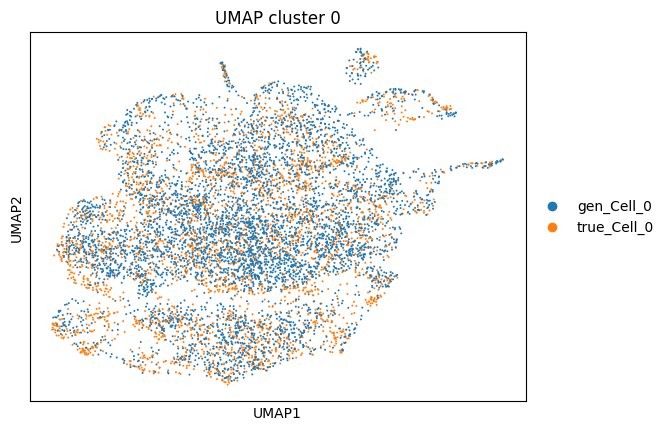

Processing cluster 1 from /Users/surprisedcat/DTU/DL/data/bulk_250000_guided_leiden1.npz


/Users/surprisedcat/DTU/DL/venv/lib/python3.13/site-packages/legacy_api_wrap/__init__.py:88: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  return fn(*args_all, **kw)


: 

In [10]:
import glob

from src.utils.dist_util import dev

# Liste des fichiers pour chaque cluster
cluster_files = sorted(glob.glob(str(PROJECT_ROOT / "data" / "bulk_250000_guided_leiden*.npz")))

for file_path in cluster_files:
    # Extraire le numéro du cluster depuis le nom du fichier
    cluster_num = file_path.split("leiden")[-1].split(".")[0]
    print(f"Processing cluster {cluster_num} from {file_path}")

    # Charger les cellules générées pour ce cluster
    npzfile = np.load(file_path)
    cell_gen_cluster = npzfile['cell_gen'][:5000]

    # Sélectionner les vraies cellules du cluster
    real_cluster_mask = adata_subset.obs['leiden'] == cluster_num
    cell_real_cluster = cell_data[real_cluster_mask]

    # Décoder les cellules générées
    autoencoder = load_VAE()
    cell_gen_decoded = autoencoder(torch.tensor(cell_gen_cluster).to(device), return_decoded=True).cpu().detach().numpy()

    # Concaténer vraies et générées
    all_cells = np.concatenate((cell_real_cluster, cell_gen_decoded), axis=0)
    cell_names = [f"true_Cell_{cluster_num}"] * cell_real_cluster.shape[0] + [f"gen_Cell_{cluster_num}"] * cell_gen_decoded.shape[0]

    # Créer AnnData et pipeline Scanpy
    adata_cluster = ad.AnnData(all_cells, dtype=np.float32)
    adata_cluster.obs['cell_name'] = cell_names

    sc.pp.highly_variable_genes(adata_cluster, min_mean=0.0125, max_mean=3, min_disp=0.5)
    adata_cluster.raw = adata_cluster
    adata_cluster = adata_cluster[:, adata_cluster.var.highly_variable]
    sc.pp.scale(adata_cluster)
    sc.tl.pca(adata_cluster, svd_solver='arpack')
    sc.pp.neighbors(adata_cluster, n_neighbors=10, n_pcs=20)
    sc.tl.umap(adata_cluster)

    # UMAP plot
    sc.pl.umap(adata_cluster, color="cell_name", size=8, title=f"UMAP cluster {cluster_num}", show=True)

In [ ]:
import glob

from src.utils.dist_util import dev

# Liste des fichiers pour chaque cluster
cluster_files = sorted(glob.glob(str(PROJECT_ROOT / "data" / "bulk_250000_guided_leiden*.npz")))


    # Extraire le numéro du cluster depuis le nom du fichier
    cluster_num = file_path.split("leiden")[-1].split(".")[0]
    print(f"Processing cluster {cluster_num} from {file_path}")

    # Charger les cellules générées pour ce cluster
    npzfile = np.load(file_path)
    cell_gen_cluster = npzfile['cell_gen'][:5000]

    # Sélectionner les vraies cellules du cluster
    real_cluster_mask = adata_subset.obs['leiden'] == cluster_num
    cell_real_cluster = cell_data[real_cluster_mask]

    # Décoder les cellules générées
    autoencoder = load_VAE()
    cell_gen_decoded = autoencoder(torch.tensor(cell_gen_cluster).to(device), return_decoded=True).cpu().detach().numpy()

    # Concaténer vraies et générées
    all_cells = np.concatenate((cell_real_cluster, cell_gen_decoded), axis=0)
    cell_names = [f"true_Cell_{cluster_num}"] * cell_real_cluster.shape[0] + [f"gen_Cell_{cluster_num}"] * cell_gen_decoded.shape[0]

    # Créer AnnData et pipeline Scanpy
    adata_cluster = ad.AnnData(all_cells, dtype=np.float32)
    adata_cluster.obs['cell_name'] = cell_names

    sc.pp.highly_variable_genes(adata_cluster, min_mean=0.0125, max_mean=3, min_disp=0.5)
    adata_cluster.raw = adata_cluster
    adata_cluster = adata_cluster[:, adata_cluster.var.highly_variable]
    sc.pp.scale(adata_cluster)
    sc.tl.pca(adata_cluster, svd_solver='arpack')
    sc.pp.neighbors(adata_cluster, n_neighbors=10, n_pcs=20)
    sc.tl.umap(adata_cluster)

    # UMAP plot
    sc.pl.umap(adata_cluster, color="cell_name", size=8, title=f"UMAP cluster {cluster_num}", show=True)